<a href="https://colab.research.google.com/github/Atharv-16/GSOC/blob/main/Task-2-Self_Supervised_Learning/Image_Classification_using_Self_Supervised_Learning_DINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and extracting dataset

In [70]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx
!unzip real_hst.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx
From (redirected): https://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx&confirm=t&uuid=c39a8214-4eb6-44df-9a8c-9cdb6d83eb74
To: /content/real_hst.zip
100% 80.5M/80.5M [00:00<00:00, 191MB/s]
Archive:  real_hst.zip
replace real_hst/nl_269_hst.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Input and output directories
input_folder = "./real_hst"
output_folder = "./output_folder"

# Output directories for classes
nl_folder = os.path.join(output_folder, "nl")
others_folder = os.path.join(output_folder, "others")
os.makedirs(nl_folder, exist_ok=True)
os.makedirs(others_folder, exist_ok=True)

# Iterate through files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".npy"):
        filepath = os.path.join(input_folder, filename)
        # Load the numpy array
        data = np.load(filepath)
        # Determine class based on filename
        if filename.startswith("nl"):
            class_folder = nl_folder
        else:
            class_folder = others_folder
        # Convert array to image and save
        img_path = os.path.join(class_folder, filename.replace(".npy", ".png"))
        plt.imsave(img_path, data, cmap='gray')  # Adjust colormap as needed


# Importing Libraries

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

# Seed value

In [73]:
def set_seed(no):
    torch.manual_seed(no)
    random.seed(no)
    np.random.seed(no)
    os.environ['PYTHONHASHSEED'] = str()
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(100)

In [74]:
print(torch.__version__)

2.2.1+cu121


# Data preprocessing and making dataloaders

In [75]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define data transformations
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Set the directory containing your data
data_dir = './output_folder'

# Use ImageFolder to load data
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Split the dataset into train and test sets (80% train, 20% test)
train_size = int(0.1 * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, test_size])

# Create data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=4)
}

# Get class names
class_names = image_dataset.classes

# Get dataset sizes
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [76]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7d11f7efcf40>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7d11f7e11b40>}

# DINO Model


In [77]:
# load dino model
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [78]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

model = DinoVisionTransformerClassifier()

# ResNet Model

In [79]:
import torch.optim as optim

model1 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 2)
model1 = model1.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [80]:
len(dataloaders["train"])

4

In [81]:
model = model.to(device)

# Training DINO

In [82]:
for epoch in range(6):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders["train"], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


# Testing DINO

In [83]:
correct = 0
total = 0
predicted_probs = []
true_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (assuming binary classification)
        _, predicted = torch.max(outputs.data, 1)
        predicted_probs.extend(probabilities.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted.to("cpu") == labels).sum().item()

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)
print(f'Accuracy of the network on the {len(dataloaders["test"])*6} test images: {100 * correct // total} %')

Accuracy of the network on the 198 test images: 68 %


# Resnet Training

In [84]:
model1 = model1.to(device)

for epoch in range(6):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders["train"], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


# ResNet Testing

In [85]:
correct1 = 0
total1 = 0
predicted_probs1 = []
true_labels1 = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model1(images.to(device))
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (assuming binary classification)
        _, predicted = torch.max(outputs.data, 1)
        predicted_probs1.extend(probabilities.cpu().numpy())
        true_labels1.extend(labels.cpu().numpy())
        total1 += labels.size(0)
        correct1 += (predicted.to("cpu") == labels).sum().item()

# Convert lists to numpy arrays
true_labels1 = np.array(true_labels1)
predicted_probs1 = np.array(predicted_probs1)
print(f'Accuracy of the network on the {len(dataloaders["test"])*6} test images: {100 * correct1 // total1} %')

Accuracy of the network on the 198 test images: 43 %


# Self-Supervised Learning (DINO) v/s Supervised Learning (ResNet)

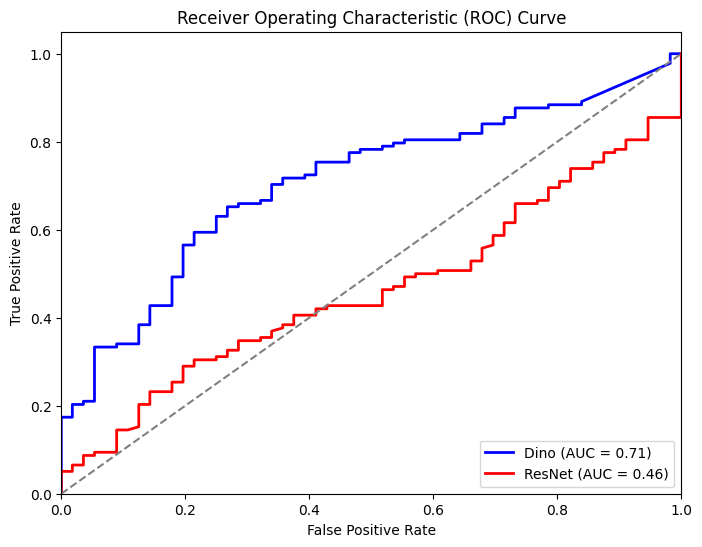

DINO AUC score:  0.7088509316770185
ResNet AUC score:  0.462797619047619


In [86]:
# Use the true labels and predicted probabilities obtained from previous testing
# Calculate ROC curve and AUC for both models
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
auc_score = auc(fpr, tpr)

fpr1, tpr1, thresholds1 = roc_curve(true_labels, predicted_probs1)
auc_score1 = auc(fpr1, tpr1)

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'Dino (AUC = {auc_score:.2f})')
plt.plot(fpr1, tpr1, color='r', lw=2, label=f'ResNet (AUC = {auc_score1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("DINO AUC score: ",auc_score)
print("ResNet AUC score: ",auc_score1)


Saving Weights

In [87]:
# Save the state_dict of the Dino model
torch.save(model.state_dict(), 'dino_model_weights.pth')


In [88]:
correct

133

In [89]:
total

194